In [ ]:
# FOR WINDOWS (your env must be called project-venv; if you choose another name add it in .gitignore)
import subprocess

# Set the execution policy
subprocess.run(["Set-ExecutionPolicy", "RemoteSigned", "-Scope", "Process"], shell=True)

# Activate the virtual environment
subprocess.run(["cd", ".\\project-venv\\"], shell=True)
subprocess.run([".\\Scripts\\Activate.ps1"], shell=True)

# Install requirements
subprocess.run(["pip", "install", "-r", "../requirements.txt"], shell=True)
subprocess.run(["pip", "install", "-r", "../emotions_requirements.txt"], shell=True)

# **Emotion Recognition task**

**import packages**

In [1]:
import cv2
import os
import random
import numpy as np
from scipy.ndimage import gaussian_filter, map_coordinates
import torch
import torch.nn as nn
from sklearn.cluster import DBSCAN
from torch.utils.data import random_split, ConcatDataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from tqdm import tqdm
import dlib
from PIL import Image
import pandas as pd

# **Paper implementation 1**
https://ieeexplore.ieee.org/abstract/document/9659697?casa_token=zDD7lwwOig8AAAAA:KcIHhupXAXgiaB_C7A0uNDB7ehrsWNyovQdgDu9LmnwToOGU6akB_gjWTy7JCf4UdKK03Is

https://github.com/serengil/deepface

If we want to use the model of the github page

In [ ]:
from deepface import DeepFace

objs = DeepFace.analyze(img_path = "img.jpg", 
        actions = ['emotion']
)

Otherwise, this is our personal implementation !

### **Dataset Augmenting**

#### **Objective:**
The purpose of this Python script is to perform data augmentation on a dataset of images corresponding to different emotions. Data augmentation is a technique commonly used in computer vision tasks to increase the diversity of the training dataset, thereby enhancing the robustness and generalization capabilities of machine learning models.

#### **Dataset Structure:**
The original dataset is organized into folders, each representing a specific emotion (e.g., angry, disgust, fear, happy, neutral, sad, surprise). Each emotion folder contains a collection of images in formats such as JPEG and PNG.

#### **Transformation Techniques:**
The script employs various image transformation techniques to augment the dataset. These techniques include:

1. **Horizontal Flip:** Flips the image horizontally.
2. **Vertical Flip:** Flips the image vertically.
3. **Zoom:** Randomly zooms into or out of the image.
4. **Translation:** Shifts the image horizontally and vertically.
5. **Contrast and Brightness Adjustment:** Randomly adjusts the contrast and brightness of the image.
6. **Elastic Transformation:** Applies a non-linear elastic deformation to the image.

#### **Implementation:**
The script uses the OpenCV library for image processing. For each emotion category, it iterates through the images, applies the defined transformations using the `apply_transformations` function, and saves the augmented images in a new folder named with the emotion followed by "_augmented."

The `elastic_transform` function generates an elastic transformation by displacing pixels based on random elastic deformations. This adds a degree of distortion to the images, contributing to further variability.

#### **Output:**
The augmented images are saved in the corresponding emotion's augmented folder, with filenames indicating the applied augmentation technique. For example, an image originally named "example_image.jpg" may result in augmented images like "example_image_aug_0.jpg," "example_image_aug_1.jpg," etc.

In [ ]:
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# cycle through emotions
for emotion in emotions:
    # path of the folder containing the images
    folder_path = fr"C:\Users\danie\Desktop\ComputerVisionProject\Data\emotions_images\{emotion}"
    output_folder_path = fr"C:\Users\danie\Desktop\ComputerVisionProject\Data\emotions_aug_images\{emotion}"


    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)

    # list of images in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # define transformations inside the apply_transformations function
    def apply_transformations(image):
        # horizontal_flip
        flipped_horizontal = cv2.flip(image, 1)

        # vertical flip
        flipped_vertical = cv2.flip(image, 0)

        # Zoom
        zoom_factor = random.uniform(0.8, 1.2)
        height, width = image.shape[:2]
        zoomed_image = cv2.resize(image, (int(width * zoom_factor), int(height * zoom_factor)))

        # translation
        tx = random.randint(-10, 10)
        ty = random.randint(-10, 10)
        translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
        translated_image = cv2.warpAffine(image, translation_matrix, (width, height))

        # contrast and brightness control
        alpha = random.uniform(0.8, 1.2)
        beta = random.randint(-35, 35)
        adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

        # elastic transformation
        elastic_image = elastic_transform(image, alpha=random.randint(6, 14), sigma=random.uniform(1.1, 2.0))

        return [image, translated_image, flipped_horizontal, zoomed_image, adjusted_image, elastic_image] #forse togliere flipped vertical

    def elastic_transform(image, alpha, sigma):
        random_state = np.random.RandomState(None)
        shape = image.shape
        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
        dz = np.zeros_like(dx)

        x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
        indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1)), np.reshape(z + dz, (-1, 1))

        distorted_image = map_coordinates(image, indices, order=1, mode='reflect')
        distorted_image = distorted_image.reshape(image.shape)

        return distorted_image

    # apply data augmentation
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)

        augmented_images = apply_transformations(image)

        # save new images
        base_name = os.path.splitext(image_file)[0]
        for i, augmented_image in enumerate(augmented_images):
            output_file_path = os.path.join(output_folder_path, f"{base_name}_aug_{i}.jpg")
            cv2.imwrite(output_file_path, augmented_image)

### **CNN Architecture: EmotionCNN**

#### **Overview:**
The `EmotionCNN` model is designed for emotion classification using a Convolutional Neural Network (CNN). Below is an overview of its architecture:

#### **Architecture Layers:**

1. **Input Layer:**
   - Input channels: 1 (grayscale images)
   - Input size: Variable (depends on the input image size)

2. **Convolutional Layer 1:**
   - Convolutional operation: 64 filters of size 5x5
   - Activation function: ReLU
   - Max pooling: 5x5 kernel with stride 2

3. **Convolutional Layers 2a and 2b:**
   - Convolutional operation: 64 filters of size 3x3
   - Activation functions: ReLU for both layers
   - Average pooling: 3x3 kernel with stride 2

4. **Convolutional Layers 3a and 3b:**
   - Convolutional operation: 128 filters of size 3x3
   - Activation functions: ReLU for both layers
   - Average pooling: 3x3 kernel with stride 2

5. **Fully Connected (FC) Layer 1:**
   - Units: 1024
   - Activation function: ReLU
   - Dropout: 20% dropout rate

6. **Fully Connected (FC) Layer 2:**
   - Units: 1024
   - Activation function: ReLU
   - Dropout: 20% dropout rate

7. **Output Layer:**
   - Units: Variable (depends on the number of emotion classes)
   - Activation function: Softmax

#### **Additional Information:**
- The architecture is designed for grayscale images (1 channel).
- The network utilizes ReLU activation functions after convolutional and fully connected layers.
- Max pooling and average pooling layers are employed for down-sampling.
- Dropout layers (20% dropout rate) are included for regularization.
- The final layer uses the softmax activation for multiclass classification.

In [2]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=5, stride=2)
        
        self.conv2a = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu2a = nn.ReLU()
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu2b = nn.ReLU()
        self.avgpool2 = nn.AvgPool2d(kernel_size=3, stride=2)
        
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3a = nn.ReLU()
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.relu3b = nn.ReLU()
        self.avgpool3 = nn.AvgPool2d(kernel_size=3, stride=2)
        
        # verify the output size of conv2 and conv3
        self.dummy_input = torch.randn(1, 1, 48, 48)
        self.dummy_output_size = self._get_conv_output_size(self.dummy_input)
        
        # update fc1 units based on feature map size
        self.fc1 = nn.Linear(self.dummy_output_size, 1024)
        self.relu_fc1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(1024, 1024)
        self.relu_fc2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(1024, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def _get_conv_output_size(self, input_tensor):
        x = self.maxpool1(self.relu1(self.conv1(input_tensor)))
        x = self.relu2a(self.conv2a(x))
        x = self.relu2b(self.conv2b(x))
        x = self.avgpool2(x)
        x = self.relu3a(self.conv3a(x))
        x = self.relu3b(self.conv3b(x))
        x = self.avgpool3(x)
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.relu2a(self.conv2a(x))
        x = self.relu2b(self.conv2b(x))
        x = self.avgpool2(x)
        x = self.relu3a(self.conv3a(x))
        x = self.relu3b(self.conv3b(x))
        x = self.avgpool3(x)
        x = x.view(x.size(0), -1)
        x = self.dropout1(self.relu_fc1(self.fc1(x)))
        x = self.dropout2(self.relu_fc2(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x

### **Hyperparameters**

The parameters that can be modified before performing training are the number of instances per label, the batch size and the number of epochs

In [3]:
number_instances_over_under_sampling_ = 30000
batch_size_ = 32
epochs_ = 23

### **Delete Outliers with DBSCAN**

#### **Objective:**
The Python script is designed to identify and remove outliers from a collection of images using the Density-Based Spatial Clustering of Applications with Noise (DBSCAN) algorithm. The primary goal is to filter out images with unusual pixel statistics, specifically focusing on standard deviation.

#### **Functions:**

1. **`calculate_pixel_std(image_path):`**
   - **Input:** Path to an image file.
   - **Output:** Returns the standard deviation of pixel values in the grayscale image.

2. **`remove_outliers_dbscan(folder_path, eps, min_samples):`**
   - **Input:**
     - `folder_path`: Path to the folder containing images.
     - `eps`: DBSCAN search radius parameter.
     - `min_samples`: Minimum number of samples required for a cluster in DBSCAN.
   - **Action:**
     - Calculates the pixel standard deviation for each image in the folder.
     - Applies DBSCAN to cluster images based on pixel standard deviation.
     - Removes outliers (images with label -1) by deleting them from the folder.
   - **Output:** Prints the number of outliers removed.

#### **Usage:**

1. Set the DBSCAN configuration parameters:
   - `dbscan_eps`: DBSCAN search radius.
   - `dbscan_min_samples`: Minimum number of samples required for a cluster.

2. Provide the path to the folder containing emotion-specific image folders (`emotions_folder_path`).

3. Iterate through each emotion folder:
   - If the emotion is 'disgust,' use different DBSCAN parameters.
   - Apply `remove_outliers_dbscan` to delete outliers in each emotion folder.

4. The script prints the number of outliers removed for each emotion.

In [ ]:
def calculate_pixel_std(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.std(image)

def remove_outliers_dbscan(folder_path, eps, min_samples):
    images = []
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        pixel_std = calculate_pixel_std(image_path)
        images.append([pixel_std])

    images = np.array(images)

    # dbscan to identify outliers
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(images)

    # remove outliers
    counter = 0
    for i, (label, image) in enumerate(zip(labels, os.listdir(folder_path))):
        if label == -1:  
            image_path = os.path.join(folder_path, image)
            os.remove(image_path)
            counter += 1
    print(counter)

# DBSCAN configuration
dbscan_eps = 0.5  # search radius
dbscan_min_samples = 10  # minimum number of samples required for a cluster

emotions_folder_path = r"C:\Users\danie\Desktop\ComputerVisionProject\Data\emotions_aug_images"


for emotion in os.listdir(emotions_folder_path):
    emotion_folder_path = os.path.join(emotions_folder_path, emotion)
    print(emotion)
    tmp_folder_path = emotion_folder_path 
    remove_outliers_dbscan(emotion_folder_path, dbscan_eps, dbscan_min_samples)


Print the path and the number of the outliers per class

In [ ]:
def calculate_pixel_std(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.std(image)

def get_outliers_dbscan(folder_path, eps, min_samples):
    images = []
    image_paths = []

    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        pixel_std = calculate_pixel_std(image_path)
        images.append([pixel_std])
        image_paths.append(image_path)

    images = np.array(images)

    # dbscan to identify outliers
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(images)

    # collect outlier paths and count for each label
    outlier_paths_by_label = {}
    for label, image_path in zip(labels, image_paths):
        if label == -1:
            if label not in outlier_paths_by_label:
                outlier_paths_by_label[label] = []
            outlier_paths_by_label[label].append(image_path)

    return outlier_paths_by_label

# Configurazione DBSCAN
dbscan_eps = 0.5  # Raggio di ricerca
dbscan_min_samples = 10  # Numero minimo di campioni in un cluster

emotions_folder_path = r"C:\Users\marco\OneDrive\Documenti\CV_project\ComputerVisionProject\Data\emotions_aug_images"

for emotion in os.listdir(emotions_folder_path):
    emotion_folder_path = os.path.join(emotions_folder_path, emotion)
    print(emotion)
    tmp_folder_path = emotion_folder_path 
    outliers = get_outliers_dbscan(emotion_folder_path, dbscan_eps, dbscan_min_samples)

    # Stampa i percorsi degli outliers per ogni label
    for label, outlier_paths in outliers.items():
        print(f"Label {label}: {len(outlier_paths)} outliers")
        for path in outlier_paths:
            print(path)


### **Over and Under sampling: Class balance**
We apply the transformations on the image dataset: grayscale, resize, conversion to tensor and normalization . Weighted random samplers handle class imbalances.

In [11]:
# transformation definition
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset_root = r'C:\Users\marco\OneDrive\Documenti\CV_project\ComputerVisionProject\Data\emotions_aug_images'

# create an instance of ImageFolder with the transformations
dataset = ImageFolder(root=dataset_root, transform=transform)

# seed = 42
torch.manual_seed(42)

# extract the labels and the indices of the dataset
labels = [label for _, label in dataset.imgs]

# convert the list into a tensor
labels = torch.tensor(labels)

# calculate the number of instances for each class
counts = torch.bincount(labels)

# calculate the weights for each class
weights = 1.0 / counts.float()

# create a weight vector for each index in the dataset
sample_weights = weights[labels]

# set the number of samples for the train set and the test set
train_size = number_instances_over_under_sampling_ * 7 * 0.8
val_size = number_instances_over_under_sampling_ * 7 * 0.1
test_size = number_instances_over_under_sampling_ * 7 * 0.1

# crea un sampler per il train set and one for the test set
train_sampler = torch.utils.data.WeightedRandomSampler(sample_weights, int(train_size))
val_sampler = torch.utils.data.WeightedRandomSampler(sample_weights, int(val_size))
test_sampler = torch.utils.data.WeightedRandomSampler(sample_weights, int(test_size))

# create a dataloader for the train set and the test set with the corresponding samplers
train_loader = DataLoader(dataset, batch_size=batch_size_, sampler=train_sampler, num_workers=4)
val_loader = DataLoader(dataset, batch_size=batch_size_, sampler=val_sampler, num_workers=4)
test_loader = DataLoader(dataset, batch_size=batch_size_, sampler=test_sampler, num_workers=4)


verifying if for each label there are number_instances_over_under_sampling instances

In [5]:
train_indices = list(train_loader.sampler)
train_counts = torch.bincount(torch.tensor(labels)[train_indices])
print("number of instances for class in the train set:", train_counts)

val_indices = list(val_loader.sampler)
val_counts = torch.bincount(torch.tensor(labels)[val_indices])
print("number of instances for class in the validation set:", val_counts)

test_indices = list(test_loader.sampler)
test_counts = torch.bincount(torch.tensor(labels)[test_indices])
print("number of instances for class in the test set:", test_counts)

number of instances for class in the train set: tensor([24215, 23930, 23907, 23856, 23931, 23907, 24254])
number of instances for class in the validation set: tensor([3052, 3019, 3029, 3027, 2921, 3047, 2905])
number of instances for class in the test set: tensor([2935, 2953, 2998, 3093, 3000, 2991, 3030])


C:\Users\marco\AppData\Local\Temp\ipykernel_3956\60523432.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_counts = torch.bincount(torch.tensor(labels)[train_indices])
C:\Users\marco\AppData\Local\Temp\ipykernel_3956\60523432.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_counts = torch.bincount(torch.tensor(labels)[val_indices])
C:\Users\marco\AppData\Local\Temp\ipykernel_3956\60523432.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_counts = torch.bincount(torch.tensor(labels)[test_indices])


In [6]:
len(train_loader), len(val_loader), len(test_loader)

(5250, 657, 657)

At the beginning these are the number of instances for each class

In [7]:
# obtain the classes (labels)
classes = dataset.classes

# count the instances for each class
instances_per_class = {cls: 0 for cls in classes}

for _, label in dataset.imgs:
    instances_per_class[classes[label]] += 1

# print("Number of instances per class:")
for cls, count in instances_per_class.items():
    print(f"Class {cls}: {count} istances")

Class angry_augmented: 29680 istances
Class disgust_augmented: 3216 istances
Class fear_augmented: 30675 istances
Class happy_augmented: 53867 istances
Class neutral_augmented: 37132 istances
Class sad_augmented: 36418 istances
Class surprise_augmented: 23981 istances


### **Emotion Recognition Training and Evaluation**

This code performs emotion recognition using a Convolutional Neural Network (CNN). Key components include:

- **Emotion Label Mapping**: Emotions are mapped to numerical values for training and evaluation.
- **Model Definition and Setup**: A CNN model, along with the criterion, optimizer, and scheduler, is defined.
- **Metrics Calculation**: The `calculate_metrics_per_class` function computes accuracy, precision, recall, F1 score, and support for each class.
- **Training Function**: The `train_epoch` function trains the model for one epoch, logging loss, accuracy, and metrics per class.
- **Evaluation Function**: The `evaluate` function assesses the model on the validation set, calculating loss, accuracy, and metrics per class.
- **Test Function**: The `test` function evaluates the model on the test set, providing loss, accuracy, and metrics per class.
- **Training and Evaluation Process**: The `train_and_evaluate` function orchestrates the entire process. It initializes WandB, sets up data transformations, creates weighted random samplers for handling class imbalances, and conducts training and validation. The best model is saved, and evaluation metrics are logged.
- **Hyperparameter Sweep Configuration**: The code supports hyperparameter optimization using WandB sweeps. Parameters include the number of instances for over/under-sampling, batch size, and epochs.

#### Training Process

The training process involves iterating through epochs, training on the specified dataset, and evaluating on validation data. Early stopping is implemented to prevent overfitting.

#### Logging and Visualization

WandB is integrated for experiment tracking. Metrics such as loss, accuracy, and metrics per class are logged during training and evaluation.

In [ ]:
your_label_mapping = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# definition of the model, criterion, optimizer and scheduler
net = EmotionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = SGD(net.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=3, verbose=True)

def calculate_metrics_per_class(true_labels, predicted_labels, label_mapping):
    unique_labels = list(label_mapping.keys())
    precision, recall, f1, support = precision_recall_fscore_support(true_labels, predicted_labels, labels=unique_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    
    metrics_per_class = {}
    for i, idx in enumerate(unique_labels):
        metrics_per_class[idx] = {
            'precision': precision[i],
            'recall': recall[i],
            'f1': f1[i],
            'support': support[i]
        }

    return accuracy, metrics_per_class

# function for training
def train_epoch(model, train_loader, criterion, optimizer, device, label_mapping):
    model.train()
    running_loss = 0.0
    true_labels = []
    predicted_labels = []

    for inputs, labels in tqdm(train_loader, desc='Training', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

    average_loss = running_loss / len(train_loader)
    accuracy, metrics_per_class = calculate_metrics_per_class(true_labels, predicted_labels, label_mapping)

    return average_loss, accuracy, metrics_per_class

# function for evaluation
def evaluate(model, val_loader, criterion, device, label_mapping):
    model.eval()
    running_loss = 0.0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    average_loss = running_loss / len(val_loader)
    accuracy, metrics_per_class = calculate_metrics_per_class(true_labels, predicted_labels, label_mapping)

    return average_loss, accuracy, metrics_per_class

# Settings
num_epochs = epochs_
early_stopping_patience = 3  # numbers of epochs with no improvement after which training will be stopped (early stopping)
best_accuracy = 0.0
best_epoch = 0
no_improvement_count = 0

# Training cycle
for epoch in range(num_epochs):
    # Training
    train_loss, train_accuracy, train_metrics_per_class = train_epoch(net, train_loader, criterion, optimizer, device, your_label_mapping)

    # Validation
    val_loss, val_accuracy, val_metrics_per_class = evaluate(net, val_loader, criterion, device, your_label_mapping)

    # Scheduler step based on validation accuracy
    scheduler.step(val_accuracy)

    # Saving the model if the current accuracy is better than the best
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_epoch = epoch
        torch.save(net.state_dict(), r'C:\Users\marco\OneDrive\Documenti\CV_project\ComputerVisionProject\Models\paper1_models\best_model.pth')
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    # Print epoch statistics
    print(f'Epoch {epoch + 1}/{num_epochs} => '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Print metrics per class
    for idx, label in your_label_mapping.items():
        print(f'{label}: Train Precision: {train_metrics_per_class[idx]["precision"]:.4f}, Train Recall: {train_metrics_per_class[idx]["recall"]:.4f}, Train F1: {train_metrics_per_class[idx]["f1"]:.4f}, Train Support: {train_metrics_per_class[idx]["support"]}')

    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    
    for idx, label in your_label_mapping.items():
        print(f'{label}: Validation Precision: {val_metrics_per_class[idx]["precision"]:.4f}, Validation Recall: {val_metrics_per_class[idx]["recall"]:.4f}, Validation F1: {val_metrics_per_class[idx]["f1"]:.4f}, Validation Support: {val_metrics_per_class[idx]["support"]}')

    if no_improvement_count >= early_stopping_patience:
        print(f'Early stopping at epoch {epoch + 1} as there is no improvement in validation accuracy for {early_stopping_patience} consecutive epochs.')
        break

print(f'Best model achieved at epoch {best_epoch + 1} with accuracy {best_accuracy:.4f}')


**Test the final model with the test set of the same dataset**

Testing:   0%|          | 0/657 [00:00<?, ?it/s]

Test Loss: 1.4552, Test Accuracy: 0.7084
Angry: Test Precision: 0.5445, Test Recall: 0.7404, Test F1: 0.6275, Test Support: 2985
Disgust: Test Precision: 0.9442, Test Recall: 0.8751, Test F1: 0.9083, Test Support: 3035
Fear: Test Precision: 0.6327, Test Recall: 0.4997, Test F1: 0.5584, Test Support: 2968
Happy: Test Precision: 0.7882, Test Recall: 0.7887, Test F1: 0.7884, Test Support: 3133
Neutral: Test Precision: 0.6297, Test Recall: 0.6724, Test F1: 0.6504, Test Support: 2848
Sad: Test Precision: 0.6673, Test Recall: 0.5405, Test F1: 0.5972, Test Support: 3040
Surprise: Test Precision: 0.7943, Test Recall: 0.8355, Test F1: 0.8144, Test Support: 2991

Recall and Precision per Label:
      Label  Precision    Recall
0     Angry   0.544469  0.740369
1   Disgust   0.944188  0.875124
2      Fear   0.632679  0.499663
3     Happy   0.788198  0.788701
4   Neutral   0.629727  0.672402
5       Sad   0.667344  0.540461
6  Surprise   0.794342  0.835507


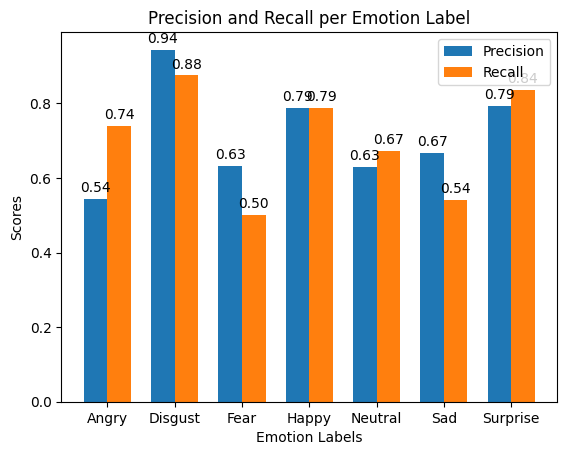

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def calculate_metrics_per_class(true_labels, predicted_labels, label_mapping):
    unique_labels = list(label_mapping.keys())
    precision, recall, f1, support = precision_recall_fscore_support(true_labels, predicted_labels, labels=unique_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    
    metrics_per_class = {}
    for i, idx in enumerate(unique_labels):
        metrics_per_class[idx] = {
            'precision': precision[i],
            'recall': recall[i],
            'f1': f1[i],
            'support': support[i]
        }

    return accuracy, metrics_per_class

# function for testing
def test(model, test_loader, criterion, device, label_mapping):
    model.eval()
    running_loss = 0.0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    average_loss = running_loss / len(test_loader)
    accuracy, metrics_per_class = calculate_metrics_per_class(true_labels, predicted_labels, label_mapping)

    return average_loss, accuracy, metrics_per_class

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the model
best_model = EmotionCNN()
best_model.load_state_dict(torch.load(r'C:\Users\marco\OneDrive\Documenti\CV_project\ComputerVisionProject\Notebooks\emotion_recognition\paper1\emotion_recognition_model.pth', map_location=device))
best_model.to(device)
criterion = nn.CrossEntropyLoss()
your_label_mapping = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}

test_loss, test_accuracy, test_metrics_per_class = test(best_model, test_loader, criterion, device, your_label_mapping)

# print the metrics per class
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

for idx, label in your_label_mapping.items():
    print(f'{label}: Test Precision: {test_metrics_per_class[idx]["precision"]:.4f}, Test Recall: {test_metrics_per_class[idx]["recall"]:.4f}, Test F1: {test_metrics_per_class[idx]["f1"]:.4f}, Test Support: {test_metrics_per_class[idx]["support"]}')


# plot the metrics per class
    
# plot the precision and the recall for each class

results_data = {'Label': [], 'Precision': [], 'Recall': []}

for idx, label in your_label_mapping.items():
    results_data['Label'].append(label)
    results_data['Precision'].append(test_metrics_per_class[idx]['precision'])
    results_data['Recall'].append(test_metrics_per_class[idx]['recall'])

results_df = pd.DataFrame(results_data)

print("\nRecall and Precision per Label:")
print(results_df)

labels = results_df['Label']

x = np.arange(len(labels))

width = 0.35
fig, ax = plt.subplots()
precision_bars = ax.bar(x - width/2, results_df['Precision'], width, label='Precision')
recall_bars = ax.bar(x + width/2, results_df['Recall'], width, label='Recall')

ax.set_xlabel('Emotion Labels')
ax.set_ylabel('Scores')
ax.set_title('Precision and Recall per Emotion Label')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

for bar in precision_bars + recall_bars:
    height = bar.get_height()
    ax.annotate('%.2f' % height,
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), 
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()


**Test the final model with a different dataset**

In [14]:
# transformation definition
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset_root = r'C:\Users\marco\OneDrive\Documenti\CV_project\ComputerVisionProject\Data\test_images_emotion'

# create an instance of ImageFolder with the transformations
dataset = ImageFolder(root=dataset_root, transform=transform)

# seed = 42
torch.manual_seed(42)

# extract the labels and the indices of the dataset
labels = [label for _, label in dataset.imgs]

# convert the list into a tensor
labels = torch.tensor(labels)

# calculate the number of instances for each class
counts = torch.bincount(labels)

# calculate the weights for each class
weights = 1.0 / counts.float()

# create a weight vector for each index in the dataset
sample_weights = weights[labels]

# set the number of samples for the train set and the test set
train_size = (number_instances_over_under_sampling_/10) * 7 * 0.1
val_size = (number_instances_over_under_sampling_/10) * 7 * 0.1
test_size = (number_instances_over_under_sampling_/10) * 7 * 0.8

# crea un sampler per il train set and one for the test set
train_sampler = torch.utils.data.WeightedRandomSampler(sample_weights, int(train_size))
val_sampler = torch.utils.data.WeightedRandomSampler(sample_weights, int(val_size))
test_sampler = torch.utils.data.WeightedRandomSampler(sample_weights, int(test_size))

# create a dataloader for the train set and the test set with the corresponding samplers
train_loader = DataLoader(dataset, batch_size=batch_size_, sampler=train_sampler, num_workers=4)
val_loader = DataLoader(dataset, batch_size=batch_size_, sampler=val_sampler, num_workers=4)
test_loader = DataLoader(dataset, batch_size=batch_size_, sampler=test_sampler, num_workers=4)

train_indices = list(train_loader.sampler)
train_counts = torch.bincount(torch.tensor(labels)[train_indices])
print("number of instances for class in the train set:", train_counts)

val_indices = list(val_loader.sampler)
val_counts = torch.bincount(torch.tensor(labels)[val_indices])
print("number of instances for class in the validation set:", val_counts)

test_indices = list(test_loader.sampler)
test_counts = torch.bincount(torch.tensor(labels)[test_indices])
print("number of instances for class in the test set:", test_counts)

number of instances for class in the train set: tensor([318, 284, 301, 303, 304, 284, 306])
number of instances for class in the validation set: tensor([305, 317, 300, 269, 294, 318, 297])
number of instances for class in the test set: tensor([2380, 2359, 2428, 2400, 2391, 2437, 2405])


C:\Users\marco\AppData\Local\Temp\ipykernel_3956\2725156309.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_counts = torch.bincount(torch.tensor(labels)[train_indices])
C:\Users\marco\AppData\Local\Temp\ipykernel_3956\2725156309.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_counts = torch.bincount(torch.tensor(labels)[val_indices])
C:\Users\marco\AppData\Local\Temp\ipykernel_3956\2725156309.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_counts = torch.bincount(torch.tensor(labels)[test_indices])


Test Loss: 1.7425, Test Accuracy: 0.4167
Angry: Test Precision: 0.3308, Test Recall: 0.5964, Test F1: 0.4255, Test Support: 2438
Disgust: Test Precision: 0.4599, Test Recall: 0.1276, Test F1: 0.1998, Test Support: 2429
Fear: Test Precision: 0.3564, Test Recall: 0.1593, Test F1: 0.2202, Test Support: 2392
Happy: Test Precision: 0.4565, Test Recall: 0.8699, Test F1: 0.5988, Test Support: 2359
Neutral: Test Precision: 0.3881, Test Recall: 0.4758, Test F1: 0.4275, Test Support: 2354
Sad: Test Precision: 0.4199, Test Recall: 0.2656, Test F1: 0.3254, Test Support: 2417
Surprise: Test Precision: 0.5951, Test Recall: 0.4322, Test F1: 0.5007, Test Support: 2411

Recall and Precision per Label:
      Label  Precision    Recall
0     Angry   0.330755  0.596390
1   Disgust   0.459941  0.127625
2      Fear   0.356408  0.159281
3     Happy   0.456507  0.869860
4   Neutral   0.388080  0.475786
5       Sad   0.419882  0.265619
6  Surprise   0.595089  0.432186


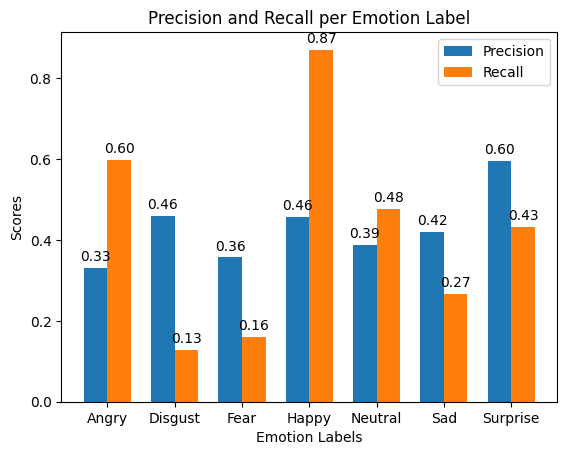

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def calculate_metrics_per_class(true_labels, predicted_labels, label_mapping):
    unique_labels = list(label_mapping.keys())
    precision, recall, f1, support = precision_recall_fscore_support(true_labels, predicted_labels, labels=unique_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    
    metrics_per_class = {}
    for i, idx in enumerate(unique_labels):
        metrics_per_class[idx] = {
            'precision': precision[i],
            'recall': recall[i],
            'f1': f1[i],
            'support': support[i]
        }

    return accuracy, metrics_per_class

# function for the test
def test(model, test_loader, criterion, device, label_mapping):
    model.eval()
    running_loss = 0.0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    average_loss = running_loss / len(test_loader)
    accuracy, metrics_per_class = calculate_metrics_per_class(true_labels, predicted_labels, label_mapping)

    return average_loss, accuracy, metrics_per_class

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the model 
best_model = EmotionCNN()
best_model.load_state_dict(torch.load(r'C:\Users\marco\OneDrive\Documenti\CV_project\ComputerVisionProject\Notebooks\emotion_recognition\paper1\emotion_recognition_model.pth', map_location=device))
best_model.to(device)
criterion = nn.CrossEntropyLoss()
your_label_mapping = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}

test_loss, test_accuracy, test_metrics_per_class = test(best_model, test_loader, criterion, device, your_label_mapping)

# print the loss and the accuracy of the model
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

for idx, label in your_label_mapping.items():
    print(f'{label}: Test Precision: {test_metrics_per_class[idx]["precision"]:.4f}, Test Recall: {test_metrics_per_class[idx]["recall"]:.4f}, Test F1: {test_metrics_per_class[idx]["f1"]:.4f}, Test Support: {test_metrics_per_class[idx]["support"]}')

# plot the precision and the recall for each class

results_data = {'Label': [], 'Precision': [], 'Recall': []}

for idx, label in your_label_mapping.items():
    results_data['Label'].append(label)
    results_data['Precision'].append(test_metrics_per_class[idx]['precision'])
    results_data['Recall'].append(test_metrics_per_class[idx]['recall'])

results_df = pd.DataFrame(results_data)

print("\nRecall and Precision per Label:")
print(results_df)

labels = results_df['Label']

x = np.arange(len(labels))

width = 0.35
fig, ax = plt.subplots()
precision_bars = ax.bar(x - width/2, results_df['Precision'], width, label='Precision')
recall_bars = ax.bar(x + width/2, results_df['Recall'], width, label='Recall')

ax.set_xlabel('Emotion Labels')
ax.set_ylabel('Scores')
ax.set_title('Precision and Recall per Emotion Label')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

for bar in precision_bars + recall_bars:
    height = bar.get_height()
    ax.annotate('%.2f' % height,
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), 
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()

### **Live emotion detection**

In [ ]:
num_classes = 7
your_label_mapping = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
model = EmotionCNN(num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(r"C:\Users\marco\OneDrive\Documenti\CV_project\ComputerVisionProject\Notebooks\emotion_recognition\paper1\emotion_recognition_model.pth", map_location=device))
model.to(device)
model.eval() 

# initialize the face detector
detector = dlib.get_frontal_face_detector()

# initialize the camera
cap = cv2.VideoCapture(0)

# apply the transformations to the face image
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

while True:
    # read a frame from the camera
    ret, frame = cap.read()

    # faces detection
    faces = detector(frame)

    # if there is at least one face detected, process the image
    if len(faces) > 0:
        # take only the first face
        face = faces[0]
        
        # cut the face from the frame
        x, y, w, h = face.left(), face.top(), face.width(), face.height()
        face_image = frame[y:y+h, x:x+w]

        # check if the face image is not empty
        if not face_image.size == 0:
            # apply the transformations to the face image
            pil_image = Image.fromarray(cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB))
            input_image = transform(pil_image).unsqueeze(0)  # Aggiunge una dimensione di batch
            input_image = input_image.to(device)

            # model prediction
            with torch.no_grad():
                output = model(input_image)

            # get the label predicted by the model
            _, predicted = torch.max(output, 1)
            predicted_emotion = your_label_mapping[predicted.item()]

            print(f'Predicted Emotion: {predicted_emotion}')

    # show the frame with the face rectangle added
    cv2.imshow("Face Detection", frame)

    # wait for 2 seconds (time in milliseconds)
    cv2.waitKey(1000)

    # if q is pressed, terminate the loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# release the capture
cap.release()
cv2.destroyAllWindows()